In [94]:
import pandahouse
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind
from scipy import stats
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt

rng = np.random.default_rng()

To verify the splitting of groups, it is necessary to conduct A/A tests (10,000 tests, for example) and see in how many cases we were able to reject the null hypothesis. If the splitting system works correctly, statistically significant differences between the two groups would only occur as a result of a random false positive. With p_value < 0.05, only in approximately 5% of cases would we obtain statistically significant differences between groups 0 and 1.

### AA test

In [95]:
connection = {'host': ' http://clickhouse.lab.karpov.courses:8123',
'database':'simulator_20241020',
'user':'student',
'password':'dpo_python_2020'
}

In [96]:
q = """
select 
   user_id,
   exp_group,
   sum(action='view') as views,
   sum(action='like') as likes,
   likes/views as ctr 
from simulator_20241020.feed_actions
where toDate(time) between '2024-12-27' and '2025-01-02' and exp_group in (2,3)
group by user_id, exp_group
"""

In [97]:
df=pandahouse.read_clickhouse(q, connection=connection)
df.head()

,user_id,exp_group,views,likes,ctr
0,78186,2,74,16,0.216216
1,115383,3,28,5,0.178571
2,10326,3,13,2,0.153846
3,131473,2,65,8,0.123077
4,36785,3,29,6,0.206897


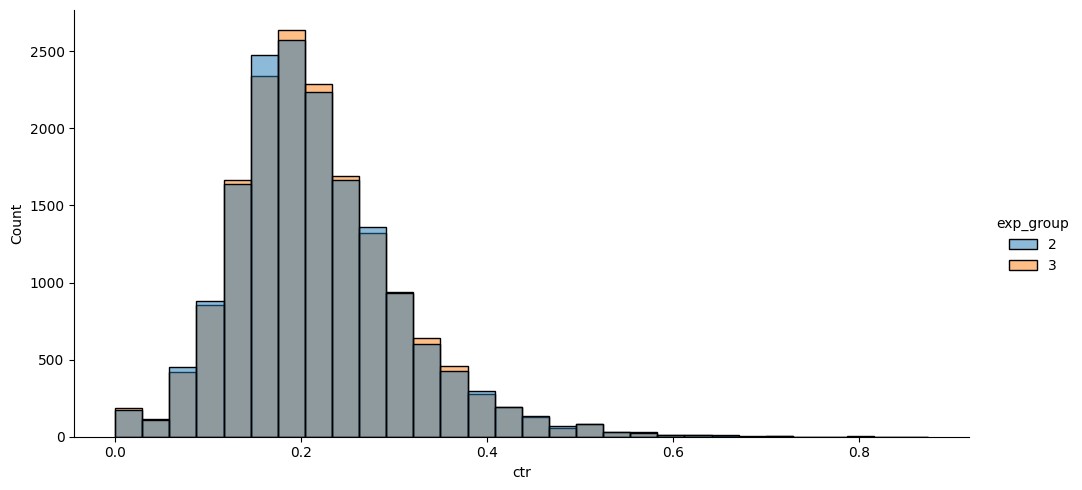

In [98]:
sns.displot(data=df, x='ctr', hue='exp_group', kde=False,palette='tab10',bins=30, height=5, aspect=2)

In [99]:
samples = 500
n_tests = 10000
p_values=[]
for i in range(n_tests):
    group_a1=df[df['exp_group']==2].ctr.sample(samples, replace=True)
    group_a2=df[df['exp_group']==3].ctr.sample(samples, replace=True)
    p_value=ttest_ind(group_a1,group_a2, equal_var=False)[1]
    p_values.append(p_value)

<Axes: ylabel='Count'>

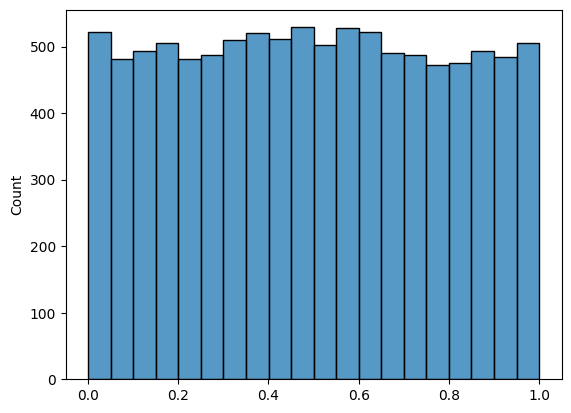

In [100]:
sns.histplot(p_values,bins=20,  kde=False)

In [101]:
sum(np.array(p_values) < 0.05) / n_tests

0.0522

The distribution of the resulting p-values is approximately uniform.The proportion of p-values below the significance threshold is approximately 0.046 (what
was expected). This means that the splitting system works correctly

### AB test

There will be an investigation of data on users who participated in A/B testing, which took place from 2025-01-03  to 2025-01-09, inclusive. Groups 2 and 1 were involved in the experiment.
**Group 2** used one of the new post recommendation algorithms (show users posts that similar users have liked), while **group 1** was used as a control. The main hypothesis is that the new algorithm in group 2 will lead to an increase in CTR.

In [102]:
connection = {'host': ' http://clickhouse.lab.karpov.courses:8123',
'database':'simulator_20250120',
'user':'student',
'password':'dpo_python_2020'
}

In [103]:
q = """
select 
   user_id,
   exp_group,
   sum(action='like') as likes,
   sum(action='view') as views,
   sum(action='like')/sum(action='view') as ctr 
from simulator_20250120.feed_actions 
where toDate(time) between '2025-01-03' and '2025-01-09' and exp_group in (1,2)
group by user_id, exp_group
"""

In [104]:
df=pandahouse.read_clickhouse(q, connection=connection)
df.head()

,user_id,exp_group,likes,views,ctr
0,109963,1,3,15,0.200000
1,26117,1,32,141,0.226950
2,138232,1,18,73,0.246575
3,26295,1,39,141,0.276596
4,18392,1,7,32,0.218750


In [105]:
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10020,10020,10020,10020
2,9877,9877,9877,9877


In [106]:
df.groupby('exp_group').ctr.mean()

exp_group
1    0.216774
2    0.216102
Name: ctr, dtype: float64

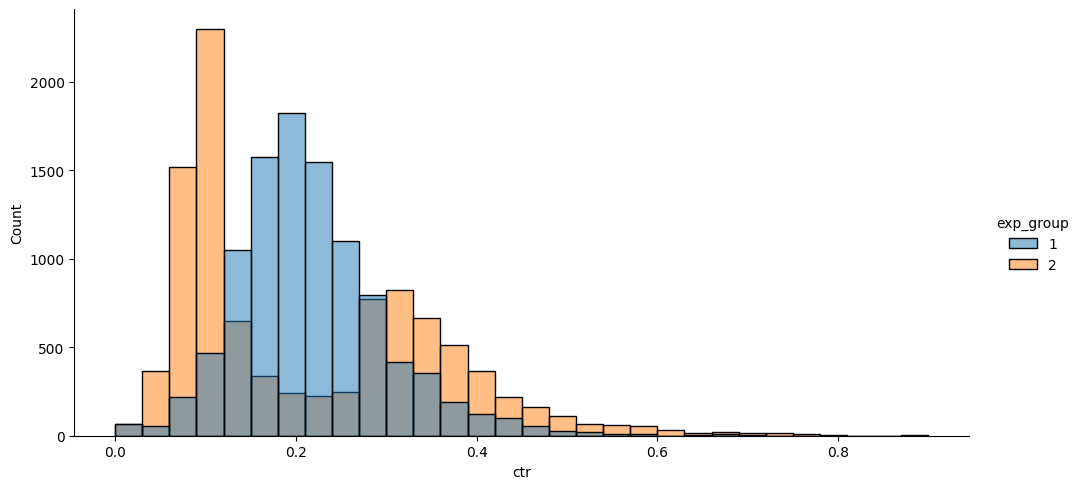

In [107]:
sns.displot(data=df, x='ctr', hue='exp_group', kde=False,palette='tab10',bins=30, height=5, aspect=2)

In [108]:
# H0 Hypothesis: P(A>B)=P(B>A)
print(stats.mannwhitneyu(df[df['exp_group']==1].ctr, df[df['exp_group']==2].ctr))

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)


There is a statistically significant difference in CTR between experimental groups 1 and 2.
The bimodality of the distribution tells us that there is a group of users who have been positively affected by the new algorithm and a group of users who have been negatively affected by it.For these reasons, the new algorithm should not be rolled out to all users.

In [109]:
print(ttest_ind(df[df['exp_group']==1].ctr, df[df['exp_group']==2].ctr, equal_var=False))

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)


Due to t-test is mean-sensitive, it cannot be applied to such highly skewed data. As a result, the t-test returns an incorrect result (2 type error, false negative, is the incorrect failure to reject a false null hypothesis)

### T-test on smoothed CTR

In [110]:
# get smothed ctr
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [111]:
global_ctr_1= df[df.exp_group == 1].likes.sum() / df[df.exp_group == 1].views.sum()
global_ctr_2= df[df.exp_group == 2].likes.sum() / df[df.exp_group == 2].views.sum()

In [112]:
group_1=df[df.exp_group == 1].copy()
group_2=df[df.exp_group == 2].copy()

In [113]:
group_1['smoothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, alpha=5), axis=1)
group_2['smoothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, alpha=5), axis=1)

In [114]:
group_1.head()

,user_id,exp_group,likes,views,ctr,smoothed_ctr
0,109963,1,3,15,0.200000,0.202401
1,26117,1,32,141,0.226950,0.226356
2,138232,1,18,73,0.246575,0.244205
3,26295,1,39,141,0.276596,0.274302
4,18392,1,7,32,0.218750,0.217514


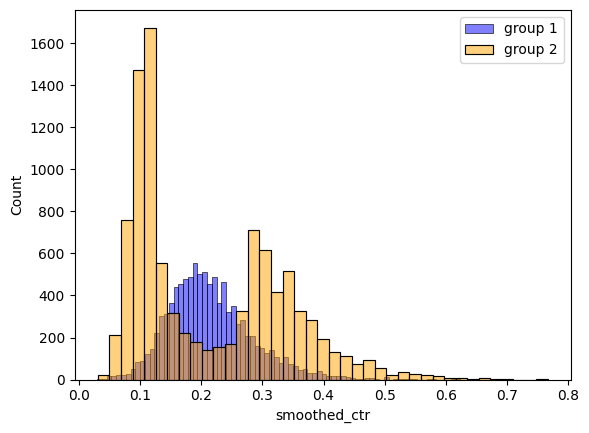

In [115]:
sns.histplot(group_1.smoothed_ctr, color='blue',alpha=0.5, label='group 1')
sns.histplot(group_2.smoothed_ctr, color='orange', alpha=0.5, label='group 2')
plt.legend()


In [116]:
# T-test on smoothed CTR
print(ttest_ind(group_1.smoothed_ctr, group_2.smoothed_ctr, equal_var=False))

Ttest_indResult(statistic=1.9460491517027683, pvalue=0.05166679015318526)


## A/B test on linearized likes 


Hypothesis testing on linearized CTR. **Group 2** used one of the new post recommendation algorithms (show users posts that similar users have liked), while **group 1** was used as a control. The main hypothesis is that the new algorithm in group 2 will lead to an increase in CTR.

In [117]:
q = """
select 
   user_id,
   exp_group,
   sum(action='like') as likes,
   sum(action='view') as views,
   sum(action='like')/sum(action='view') as ctr 
from simulator_20250120.feed_actions 
where toDate(time) between '2025-01-03' and '2025-01-09' and exp_group in (1,2)
group by user_id, exp_group
"""

df=pandahouse.read_clickhouse(q, connection=connection)

In [118]:
df['ctr_control']=df[df['exp_group']==1].likes.sum()/ df[df['exp_group']==1].views.sum()
df['linearized_likes']=df.likes-df.ctr_control*df.views

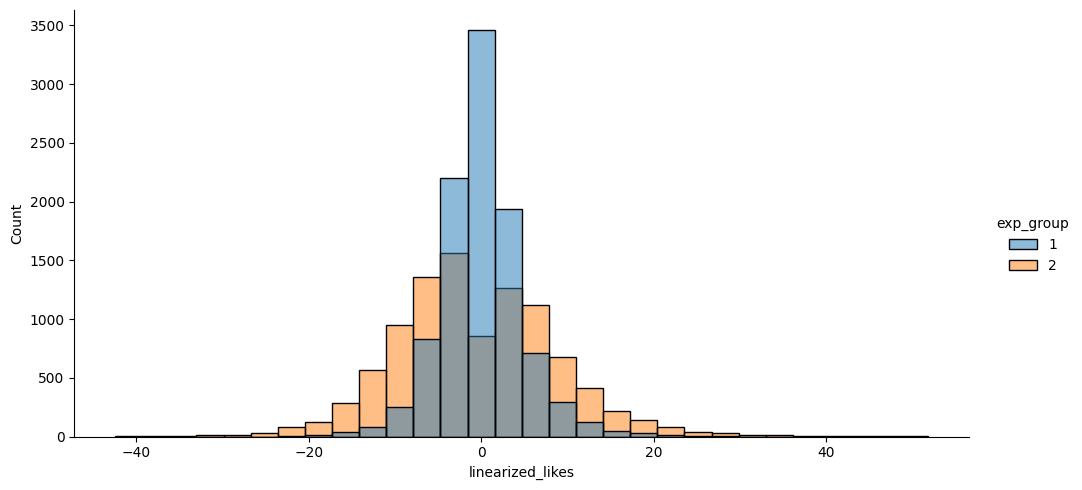

In [119]:
sns.displot(data=df[df['exp_group'].isin([1,2])], x='linearized_likes', hue='exp_group', kde=False,palette='tab10',bins=30, height=5, aspect=2)

In [120]:
print(ttest_ind(df[df['exp_group']==1].linearized_likes, df[df['exp_group']==2].linearized_likes, equal_var=False))

Ttest_indResult(statistic=5.936377101934481, pvalue=2.9805064038667945e-09)


In [121]:
print(stats.mannwhitneyu(df[df['exp_group']==1].ctr, df[df['exp_group']==2].linearized_likes))

MannwhitneyuResult(statistic=55176474.0, pvalue=7.416111998094547e-45)


On linerized CTR, Ttest and Mannwhitney test are showing, that there is a statistically significant difference in CTR between experimental groups 1 and 2. 
The sensitivity of the tests has increased, allowing differences to be detected when performing t-tests.  